In [1]:
import numpy as np

from scipy import sparse
from scipy import linalg as la
from scipy.sparse import linalg as spla

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

In [2]:
plt.rc("figure", dpi=300, figsize=(12,4))
plt.rc("font", family="serif")
plt.rc("text", usetex=True)

np.random.seed(10)

<h1><center>Sampling low-dimensional Markovian dynamics for pre-asymptotically recovering reduced models from data with operator inference</center></h1>

<center>Paper by
Benjamin Peherstorfer
</center>
<center>Code and presentation by
Shane McQuarrie
</center>
<center>
CSE 392: SCIENTIF COMP MACH/DEEP LRN
</center>
<center>
10 December 2019
</center>

Read the first draft of the paper [here](https://arxiv.org/pdf/1908.11233.pdf).

### Outline
1. **Toy Example** showing how the reduced model given by operator inference can differ significantly from the intrusive reduced model
2. **Implementation** of re-projection for discrete and continuous systems
3. **Numerical Example 1**: heat equation
4. **Numerical Example 2**: Burgers' equation

## Toy Example (wherein the operator inference model differs from the intrusive model)

Consider the discrete dynamical system
$$
    \mathbf{x}_{j+1} = A\mathbf{x}_j,
    \qquad
    \mathbf{x}_0 = \left[\begin{array}{c}1 \\ 0 \\ \vdots \\ 0\end{array}\right] \in\mathbb{R}^{n},
$$
where $A\in \mathbb{R}^{n\times n}$ is chosen by sampling entries uniformly in $[0,1]$ and then transforming them to ensure the eigenvalues of $A$ have absolute values less than $1$.
More precisely, we let $D$ be a diagonal matrix whose entries lie in $[.9,.99]$, $W$ be an orthonormal matrix, and $A = W^\mathsf{T}DW$.
Let $V\in\mathbb{R}^{n\times r}$ be the matrix whose columns are first $r$ columns of the $n\times n$ identity matrix.

Given the trajectory (training data)
$$
    X = \left[\begin{array}{c|c|c|c}
    & & & \\
    \mathbf{x}_0 & \mathbf{x}_1 & \cdots & \mathbf{x}_{k-1}
    \\ & & &
    \end{array}\right]\in\mathbb{R}^{n\times k},
$$
we compute and compare three different reduced-dimension trajectories:
- The _projected trajectory_ $\breve{X} = V^\mathsf{T} X$,
- The _intrusive trajectory_ $\tilde{X}$ generated by the intrusive model $\tilde{\mathbf{x}}_{j+1} = V^\mathsf{T}A V \tilde{\mathbf{x}}_{j}$, and
- The _inferred trajectory_ $\hat{X}$ generated by the model learned through operator inference, $\hat{\mathbf{x}}_{j+1} = \hat{A}\hat{\mathbf{x}}_{j}$.

In [3]:
# Choose dimensions.
n = 10              # Original state dimension.
r = 2               # Reduced state dimension.
k = 101             # Number of snapshots.

# Generate an nxn matrix whose eigenvalues are within the open unit disc.
I = np.eye(n)
D = np.diag(1 - np.logspace(-1, -2, n))
W = la.qr(np.random.normal(size=(n,n)))[0]
A = W.T @ D @ W
print("eigenvalues of A:", la.eigvals(A), sep='\n')

eigenvalues of A:
[0.9       +0.j 0.92257363+0.j 0.94005157+0.j 0.95358411+0.j
 0.96406186+0.j 0.99      +0.j 0.9870845 +0.j 0.98331899+0.j
 0.97845565+0.j 0.97217441+0.j]


In [4]:
# Set the initial condition vector and choose the basis matrix.
x0_train = I[:,0]           # x0 = [1, 0, 0, ...] for training.
V = I[:,:r]                 # vj = ej (canonical basis) for j = 1, ..., r.
x0_test = x0_train.copy()   # x0 = [1, 1, 0, ...] for testing.
x0_test[1] = 1

In [5]:
def evolve_system(f, x0, k, u=None):
    """Step the discrete dynamical system
        x_{j+1} = f(x_{j}, u_{j});  x_{0} = x0
    forward K steps.

    Parameters
    ----------
    f : callable mapping (n,) ndarray to (n,) ndarray
        Function defining the dynamical system.

    x0 : (n,) ndarray
        Initial condition for the iteration.

    K : int
        The number of iterations to do.

    u : (k-1,) ndarray
        Scalar inputs, one for each iteration beyond the initial condition.

    Returns
    -------
    X : (n,k) ndarray
        Dynamical states; the jth column, X[:,j], is the jth N-dimensional state.
    """
    # Create the solution array and fill in the initial condition.
    X = np.empty((len(x0),k))
    X[:,0] = x0.copy()

    # Run the iteration.
    if u is None:
        for j in range(k-1):
            X[:,j+1] = f(X[:,j])
    else:
        for j in range(k-1):
            X[:,j+1] = f(X[:,j], u[j])

    return X

In [6]:
def FOM(x):
    """Do one step of the full-order model."""
    return A @ x

In [7]:
# Generate "snapshots" by running the forward model.
X_train = evolve_system(FOM, x0_train, k)
X_test  = evolve_system(FOM, x0_test,  k)

X_train.shape

(10, 101)

In [8]:
X_projected_train = V.T @ X_train                   # Project the state snapshots.
X_projected_test  = V.T @ X_test                    # Project the state snapshots.

X_projected_train.shape

(2, 101)

In [9]:
# Construct the intrusive model.
Atilde = V.T @ A @ V
print("shape(Atilde):", Atilde.shape)

def ROM_intrusive(x_):
    """Do one step of the ROM generated by intrusive projection."""
    return Atilde @ x_

shape(Atilde): (2, 2)


In [10]:
def infer_linear_discrete_state_operator(X_):
    """Solve the operator inference least squares problem for a linear discrete model.

    Parameters
    ----------
    X_ : (r,k) ndarray
        The projected trajectory (training data), i.e., X_ = V.T @ X.

    Returns
    -------
    Ahat : (r,r) ndarray
        The operator A_ in the reduced order model.
    """
    return la.lstsq(X_[:,:-1].T, X_[:, 1:].T)[0].T

In [11]:
# Construct the operator inference model.
Ahat = infer_linear_discrete_state_operator(X_projected_train)
print("shape(Ahat):", Ahat.shape)

def ROM_inference(x_):
    """Do one step of the ROM generated by operator inference."""
    return Ahat @ x_

shape(Ahat): (2, 2)


Now we compare the intrusive operator $\tilde{A} = V_n^\mathsf{T} A V_n$ to the inferred operator $\hat{A}$.

In [12]:
print(Atilde, ' Atilde (intrusive)\n\n',
      Ahat, ' Ahat (operator inference)', sep='')

[[ 0.95630885 -0.00137208]
 [-0.00137208  0.95318219]] Atilde (intrusive)

[[ 0.95957551 -0.25374006]
 [-0.00192874  0.97753088]] Ahat (operator inference)


In [13]:
print("eigenvalues(Atilde):\t", la.eigvals(Atilde),
      "\neigenvalues(Ahat):\t", la.eigvals(Ahat), sep='')

eigenvalues(Atilde):	[0.95682557+0.j 0.95266548+0.j]
eigenvalues(Ahat):	[0.94467859+0.j 0.99242781+0.j]


Now we generate the trajectories $\tilde{X}$ and $\hat{X}$ (we already have $\breve{X}$) and compare them.

In [14]:
# Project initial conditions.
x0_train_ = V.T @ x0_train
x0_test_ = V.T @ x0_test

# Run the reduced order model.
X_intrusive_train = evolve_system(ROM_intrusive, x0_train_, k)
X_intrusive_test = evolve_system(ROM_intrusive, x0_test_, k)

X_intrusive_train.shape

(2, 101)

In [15]:
X_inferred_train = evolve_system(ROM_inference, x0_train_, k)
X_inferred_test = evolve_system(ROM_inference, x0_test_, k)

X_inferred_train.shape

(2, 101)

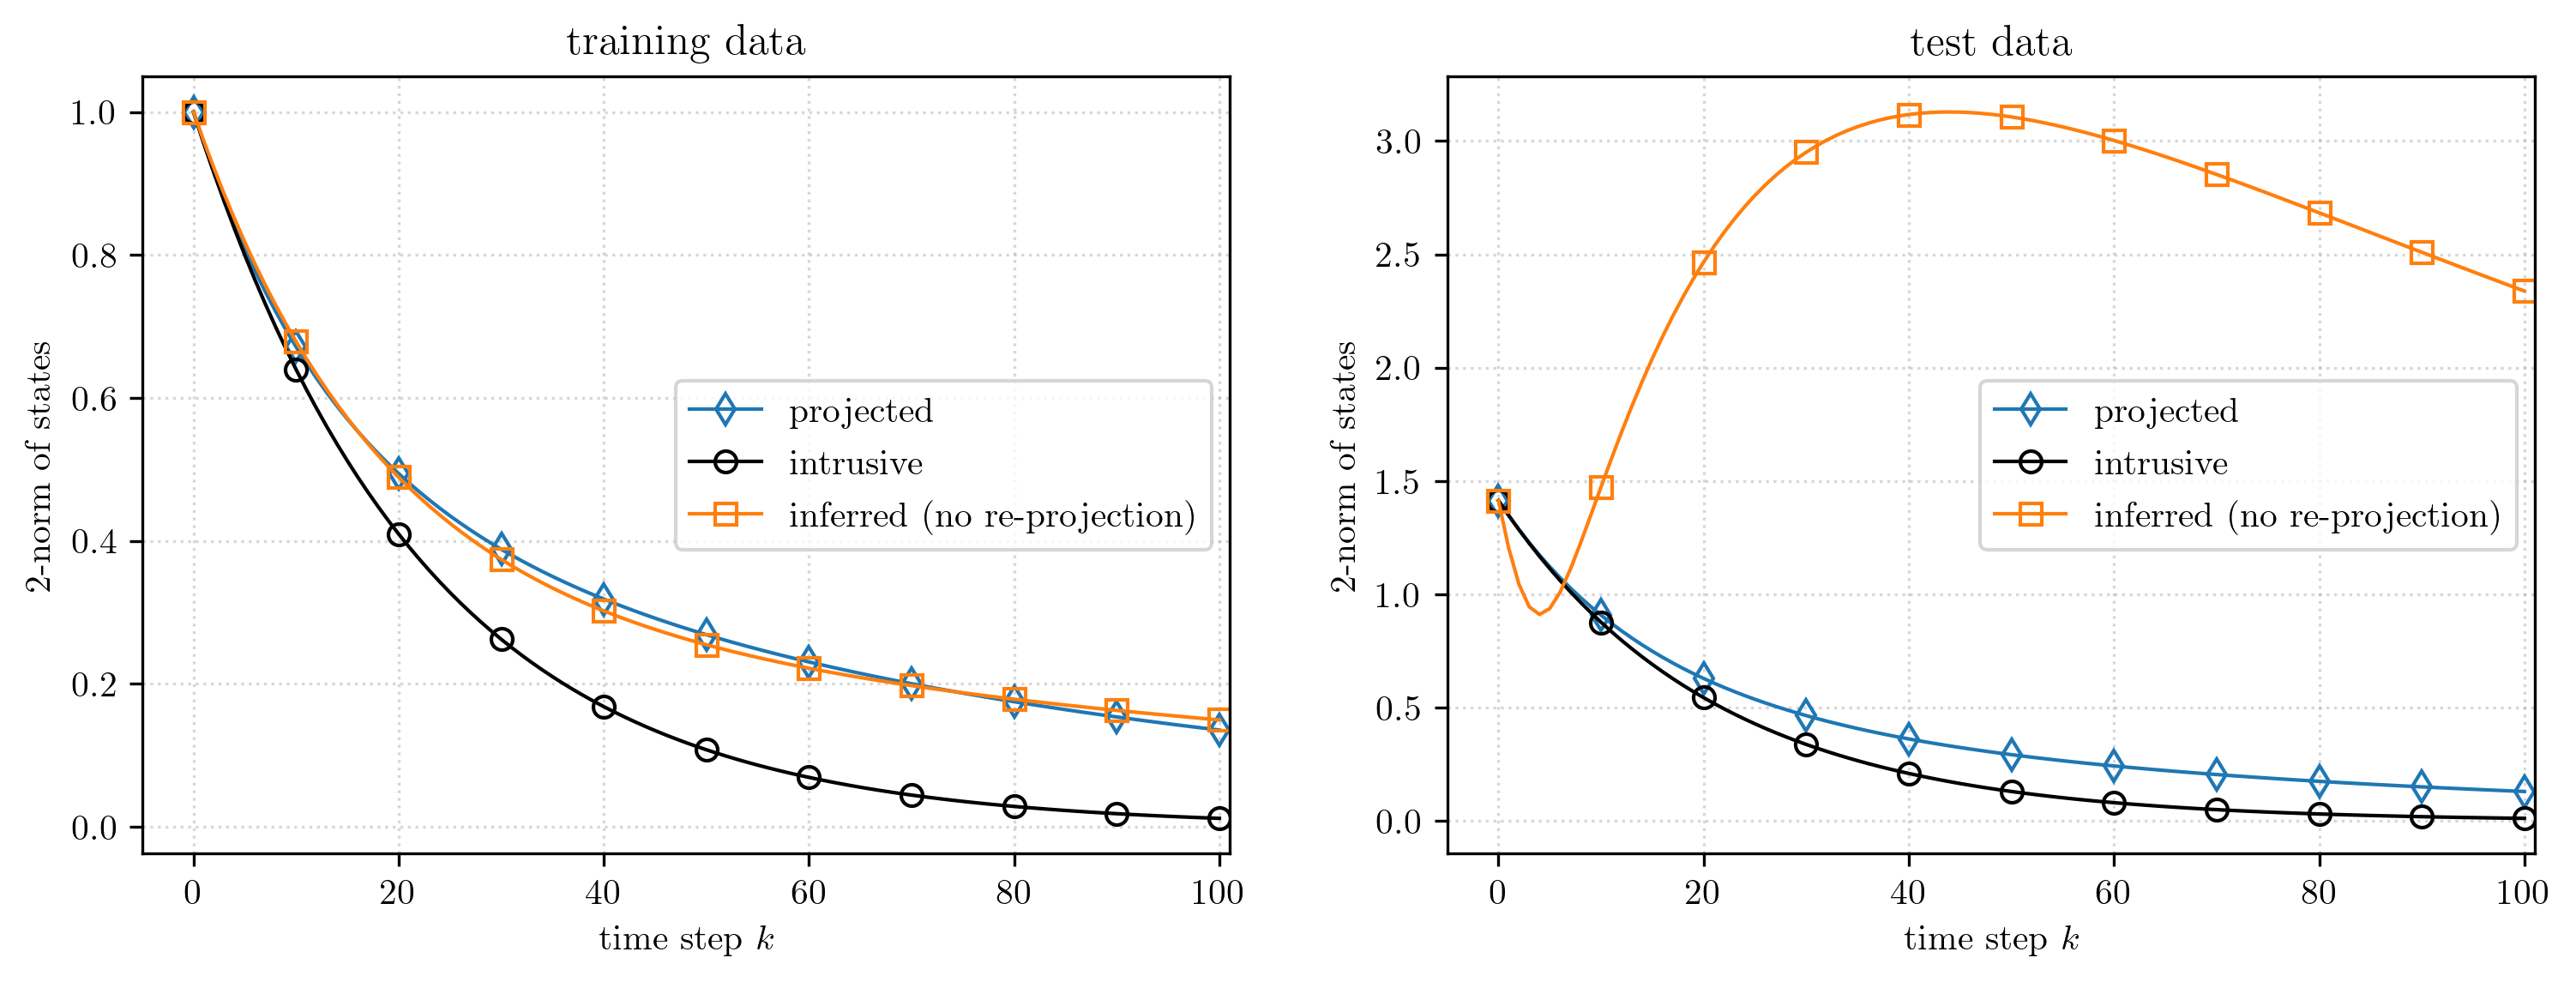

In [16]:
fig, [ax1,ax2] = plt.subplots(1, 2, sharex=True)

ax1.plot(la.norm(X_projected_train, axis=0), color='C0', lw=1, marker='d', mew=1, mfc='none', markevery=10, label="projected")
ax1.plot(la.norm(X_intrusive_train, axis=0), color='k',  lw=1, marker='o', mew=1, mfc='none', markevery=10, label="intrusive")
ax1.plot(la.norm(X_inferred_train,  axis=0), color='C1', lw=1, marker='s', mew=1, mfc='none', markevery=10, label="inferred (no re-projection)")
ax1.grid(ls=':', alpha=.5)
ax1.legend(loc="center right")
ax1.set_xlim(right=k)
ax1.set_xlabel(r"time step $k$")
ax1.set_ylabel(r"2-norm of states")
ax1.set_title("training data")

ax2.plot(la.norm(X_projected_test, axis=0), color='C0', lw=1, marker='d', mew=1, mfc='none', markevery=10, label="projected")
ax2.plot(la.norm(X_intrusive_test, axis=0), color='k',  lw=1, marker='o', mew=1, mfc='none', markevery=10, label="intrusive")
ax2.plot(la.norm(X_inferred_test,  axis=0), color='C1', lw=1, marker='s', mew=1, mfc='none', markevery=10, label="inferred (no re-projection)")
ax2.grid(ls=':', alpha=.5)
ax2.legend(loc="center right")
ax2.set_xlabel(r"time step $k$")
ax2.set_ylabel(r"2-norm of states")
ax2.set_title("test data")

plt.show()

On the one hand, the operator inference solution matches the projected trajectory better than the intrusive solution when using the same initial condition as the training data.
On the other hand, operator inference fails dramatically on an initial condition that was not used to generate the data.
In the paper ($\S$2.4 and Figure 1), the code used to generate the example had a missing transpose operator which caused the operator inference solution to look much worse on the training data than it actually is.
However, our corrected version of the experiment shows that operator inference can fit to data better than the intrusive model, but that the intrusive model can be more robust for different initial conditions.
We have chosen a particularly bad case to display, but results are similar with other random seeds.
This overfitting of sorts can be remedied by re-projection, which gives us the intrusive operator.

## Implementation of Re-projection

The goal of re-projection is to recover the intrusive model via operator inference.
To do so, we compute the data that would have been produced by the intrusive model in the reduced space, i.e, set

$$
    \tilde{\mathbf{x}}_0 = V^\mathsf{T}\mathbf{x}_0,
    \qquad
    \tilde{\mathbf{x}}_{j+1} = V^\mathsf{T}\mathbf{f}(V\tilde{\mathbf{x}}_j).
$$

In [17]:
def reproject_discrete(f, V, x0, K, u=None):
    """Sample re-projected trajectories of the discrete system
        x_{j+1} = f(x_{j}, u_{j}),  x_{0} = x0
    using the basis V for k time steps.

    Parameters
    ----------
    f : callable mapping (n,) ndarray to (n,) ndarray
        Function defining the dynamical system.

    V : (n,r) ndarray
        Basis for the low-dimensional linear subspace.

    x0 : (n,) ndarray
        Initial condition for the iteration.

    K : int
        The number of iterations to do.

    u : (k-1,) ndarray
        Scalar inputs, one for each iteration beyond the initial condition.

    Returns
    -------
    X_ : (r,k) ndarray
        Re-projected state trajectories in the low-dimensional space.
    """
    # Create the solution array and fill in the initial condition.
    n,r = V.shape
    X_ = np.empty((r,k))
    X_[:,0] = V.T @ x0

    # Run the iteration.
    if u is None:
        for j in range(k-1):
            X_[:,j+1] = V.T @ f(V @ X_[:,j])
    else:
        for j in range(k-1):
            X_[:,j+1] = V.T @ f(V @ X_[:,j], u[j])

    return X_

In [18]:
X_reprojected = reproject_discrete(lambda x: A @ x, V, x0_train, k)
X_reprojected.shape

(2, 101)

In [19]:
Ahatnew = infer_linear_discrete_state_operator(X_reprojected)
Ahatnew.shape

(2, 2)

In [20]:
# The big test!
np.allclose(Ahatnew, Atilde)

True

That is, by using the reprojected data, the inferred operator $\hat{A}$ is exactly equal to the intrusive operator $\tilde{A}$.
IT WORKS!

## Example 1: Heat Equation

Consider the equation
$$
\begin{align*}
    \frac{\partial x}{\partial t} - \mu\frac{\partial^2 x }{\partial \omega^2} &= 0
    &
    &\forall (\omega,t)\in [0,1] \times(0,T]\\
    x(0,t) = x(L,t) &= 0
    &
    &\forall t\in[0,T],
    \\
    x(\omega,0) &= g(\omega)
    &
    &\forall \omega\in[-1,1].
\end{align*}
$$

To solve the problem numerically, let $\{\omega_i\}_{i=0}^{n+1}$ be an equidistant grid of $n+2$ points on $\Omega$, i.e.,
$$
\begin{align*}
    0 &= \omega_0 < \omega_1 < \cdots < \omega_n < \omega_{n+1} = L
    &
    &\text{and}
    &
    \delta\omega &= \frac{L}{n+1} = \omega_{i+1} - \omega_{i},\quad i=1,\ldots,n-1.
\end{align*}
$$

Since the boundary conditions prescribe $x(\omega_0,t) = x(\omega_{n+1},t) = 0$, we wish to compute the state vector

$$
\mathbf{x}(t) = \left[\begin{array}{c} x(\omega_1,t) \\ \vdots \\ x(\omega_n,t)\end{array}\right]\in\mathbb{R}^n
$$

for various $t\in[0,T]$.

Introducing the finite difference approximation

$$
\begin{align*}
    \frac{\partial^2}{\partial\omega^2}x(\omega,t) &\approx \frac{x(\omega-\delta\omega,t) - 2x(\omega,t) + x(\omega+\delta\omega,t)}{(\delta\omega)^2}
    % &
    % \Longrightarrow&
    % &
    % \frac{\partial^2}{\partial\omega^2}x(\omega_i,t) &\approx \frac{x(\omega_{i-1},t) - 2x(\omega_{i},t) + x(\omega_{i+1},t)}{(\delta\omega)^2}
    % \\
    &
    &\Longrightarrow
    &
    \frac{\partial^2}{\partial\omega^2}x_{i} &\approx \frac{x_{i-1} - 2x_{i} + x_{i+1}}{(\delta\omega)^2},
\end{align*}
$$

we obtain the semi-discrete linear system

$$
\boxed{
\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t),
\qquad
\mathbf{x}(0) = \mathbf{x}_0
}\,,
$$

where

$$
\begin{align*}
    A &= \frac{\mu}{(\delta\omega)^2}\left[\begin{array}{ccccc}
        -2 & 1 & & & \\
        1 & -2 & 1 & & \\
        & \ddots & \ddots & \ddots & \\
        & & 1 & -2 & 1 \\
        & & & 1 & -2 \\
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    \mathbf{x}_0 &= \left[\begin{array}{c}
    g(\omega_1) \\ g(\omega_2) \\ \vdots \\ g(\omega_{n-1}) \\ g(\omega_n)
    \end{array}\right] \in\mathbb{R}^{n}.
\end{align*}
$$

### Discrete Case

The boxed equation is the _continuous full-order model_ (FOM).
To use re-projection as currently implemented, we must also discretize the continuous FOM to obtain a discrete FOM.
First, we begin by constructing the spatial and temporal domains and the full-order state matrix $A$.
For simplicity, we set $L = 1$, $T = 1$, and $\mu = 1$.

In [21]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**10 - 1                   # Spatial grid size.
w_all = np.linspace(0, L, n+2)  # Full spatial grid.
w = w_all[1:-1]                 # Interior spatial grid (where x is unknown).
dw = w[1] - w[0]                # Spatial resolution.

# Construct the temporal domain.
T = 1                           # Temporal domain length (final simulation time).
k = T*10**4+1                   # Temporal grid size.
t = np.linspace(0, T, k)        # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

# Set other parameters.
µ = 1                           # Diffusivity coefficient.

print(f"Spatial step size dw = {dw}")
print(f"Temporal step size dt = {dt}")

Spatial step size dw = 0.0009765625
Temporal step size dt = 0.0001


In [22]:
# Construct state matrix A.
dw2inv = 1 / dw**2
diags = np.array([1,-2,1]) * dw2inv
A = sparse.diags(diags, [-1,0,1], (n,n)).tocsc()

# Construct an initial condition.
x0 = 2*np.sin(9*np.pi*w) - np.sin(4*np.pi*w) + 3*w*(1 - w)

print(f"shape of A:\t{A.shape}")
print(f"shape of x0:\t{x0.shape}")

shape of A:	(1023, 1023)
shape of x0:	(1023,)


To solve the continuous full-order model, we employ the Implicit Euler method with a uniform time step $\delta t$.
Since the differential equation is of the form $d\mathbf{x}/dt = A\mathbf{x}(t) =: f(\mathbf{x})$, the method can be written as

$$
    \mathbf{x}_{j+1}
    = \mathbf{x}_{j} + \delta t f(\mathbf{x}_{j+1})
    = \mathbf{x}_{j} + \delta t A\mathbf{x}_{j+1}
    \quad\Longrightarrow\quad
    \mathbf{x}_{j+1} = (I - \delta t A)^{-1}\mathbf{x}_{j}.
$$

This last equation is the discrete full-order model.
Our goal is to construct a discrete reduced-order model (ROM) that approximates the discrete model.
In particular, we want to see if re-projected operator inference can produce the same reduced state operator as the discrete intrusive model, $\tilde{A} = V^\mathsf{T} (I - \delta t A)^{-1} V$.
One advantage is that operator inference will not need to construct $(I - \delta t A)^{-1}$ explicitly.

In [23]:
def implicit_euler_step(A, x0, dt):
    """Do one Implicit Euler step for solving the system

        dx / dt = Ax(t),    x(0) = x0,

    i.e., x_{n+1} = (I - dt*A)^{-1}x_{n}.

    Parameters
    ----------
    A : (n,n) ndarray
        State matrix.

    x0 : (n,) ndarray
        Initial condition.

    dt : float
        Time step.

    Returns
    -------
    x : (n,) ndarray
        Solution to the ODE at the next time step.
    """
    if sparse.issparse(A):
        return spla.spsolve(sparse.eye(len(x0)) - dt*A, x0)
    else:
        return la.solve(np.eye(len(x0)) - dt*A, x0)

In [24]:
def FOM(x):
    """Do a single step of the full-order model."""
    return implicit_euler_step(A, x, dt)

In [25]:
X = evolve_system(FOM, x0, k)
X.shape

(1023, 10001)

In [26]:
def plot_heat_solution(X, jmax=200, title=None, ax=None):
    """Plot the solution in space at each time."""
    if ax is None:
        ax = plt.gca()

    color = plt.cm.plasma_r(np.linspace(0,1,jmax))
    for j in range(jmax):
        ax.plot(w, X[:,j], c=color[j])

    ax.set_title(title)
    plt.colorbar(plt.cm.ScalarMappable(Normalize(0, jmax), "plasma_r"), ax=ax).set_label("iteration (time)")

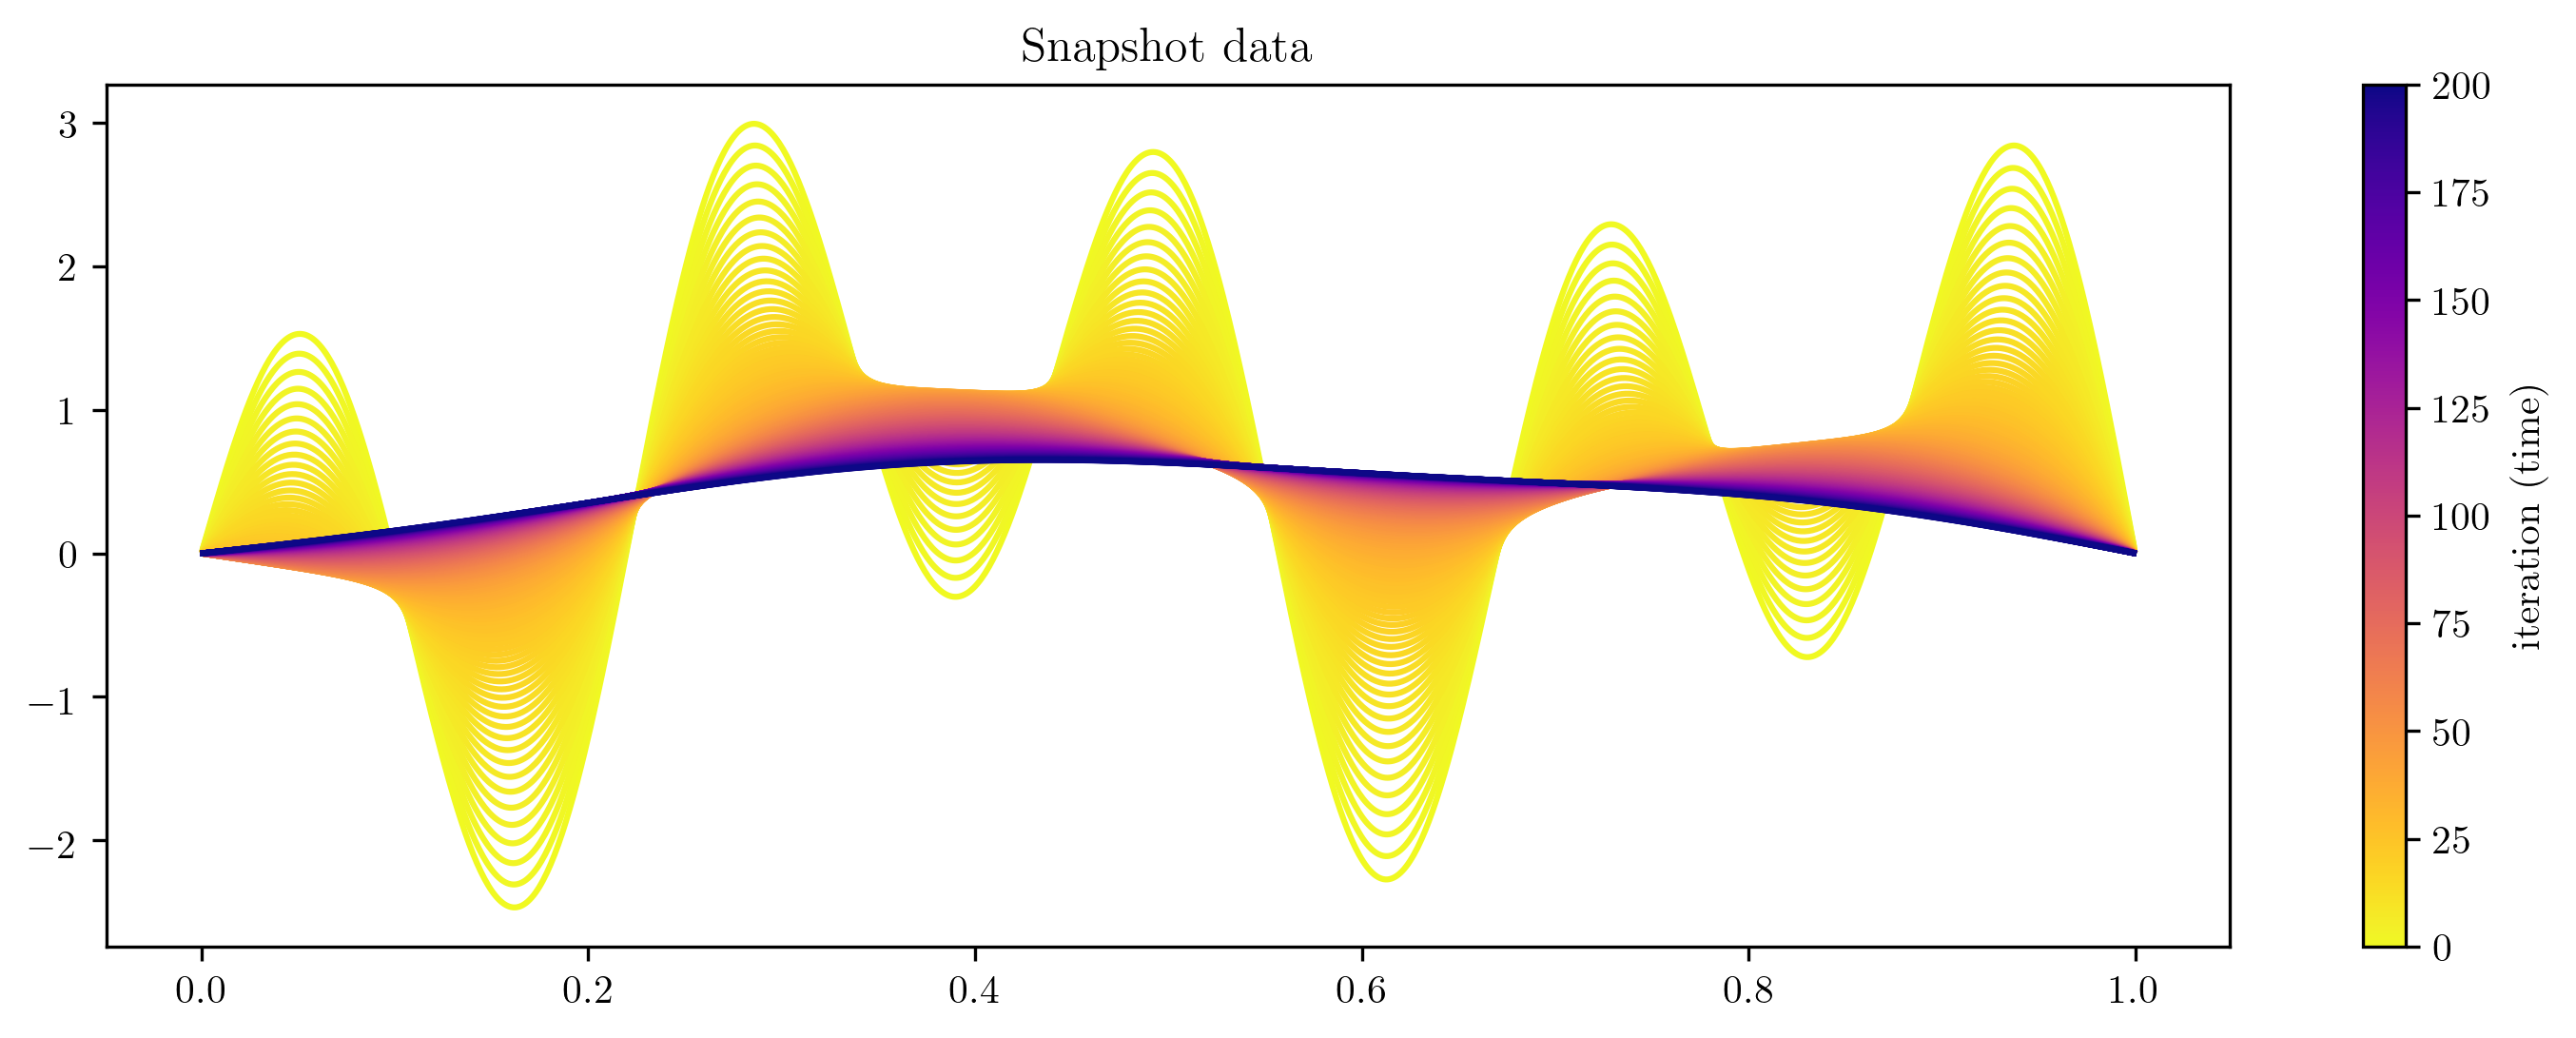

In [27]:
plot_heat_solution(X, title="Snapshot data")

Next, we derive a basis $V$ from the snapshots.

In [28]:
def plot_singular_values(X):
    Xsvdvals = la.svdvals(X)
    plt.semilogy(Xsvdvals, 'k*', mew=0)
    plt.xlabel(r"index $j$")
    plt.ylabel(r"singular value $\sigma_j$")
    plt.show()
    return Xsvdvals

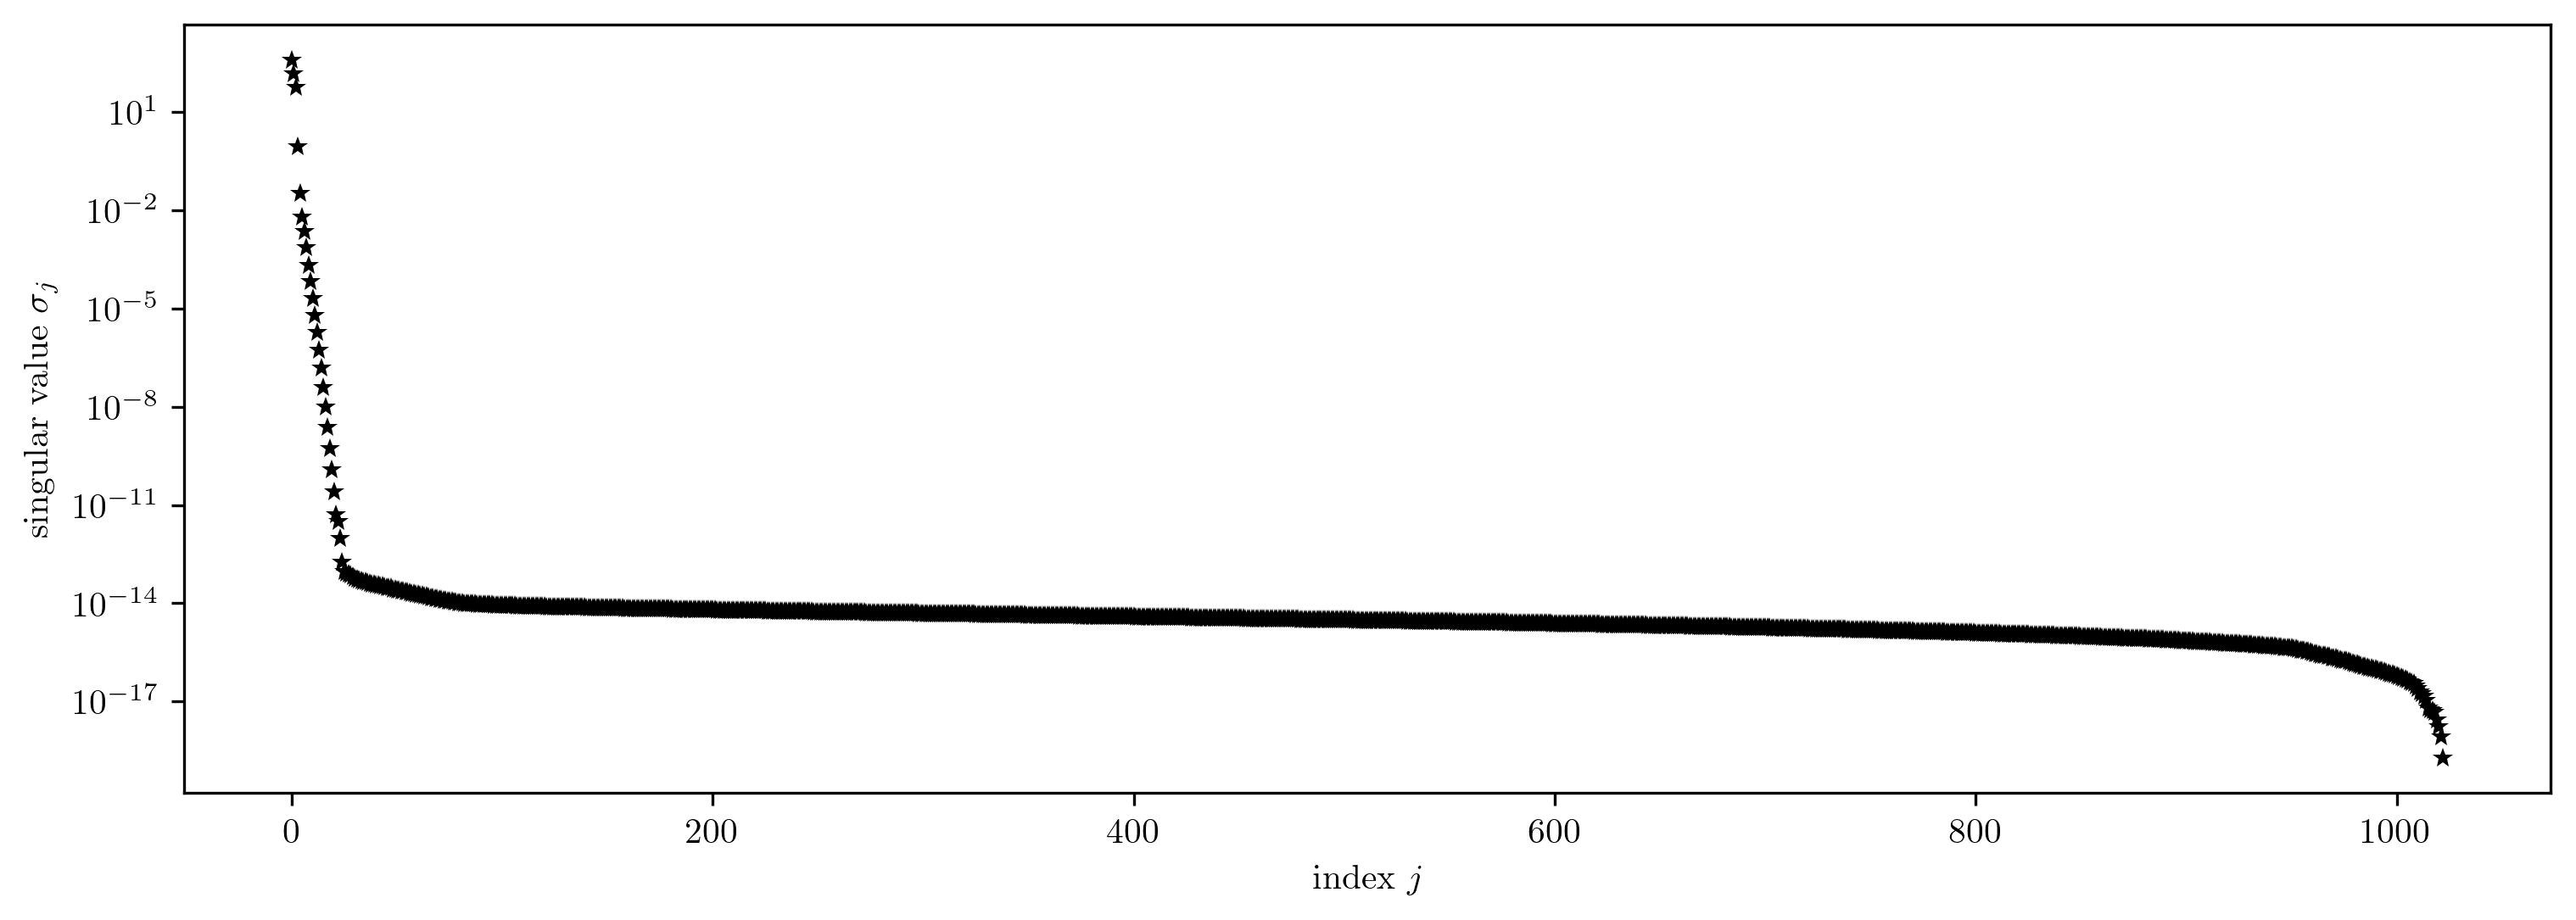

In [29]:
Xsvdvals = plot_singular_values(X)

In [30]:
r = 8                               # Choice of reduced dimension.
V = la.svd(X)[0][:,:r]              # Compute the POD Basis.
V.shape

(1023, 8)

In [31]:
def plot_basis_vectors(V, Xsvdvals, w):
    """Visualize the computed basis vectors; all solutions to the ROM
    are linear combinations of these vectors.
    """
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12,6))
    for j, ax in enumerate(axes.flat):
        ax.plot(w, V[:,j])
        ax.set_title(rf"$\sigma_{{{j+1}}}\approx {Xsvdvals[j]:.4f}$")
    axes[0,0].set_xlim(w.min(), w.max())
    # axes[0,0].set_ylim(-.1,.1)
    plt.show()

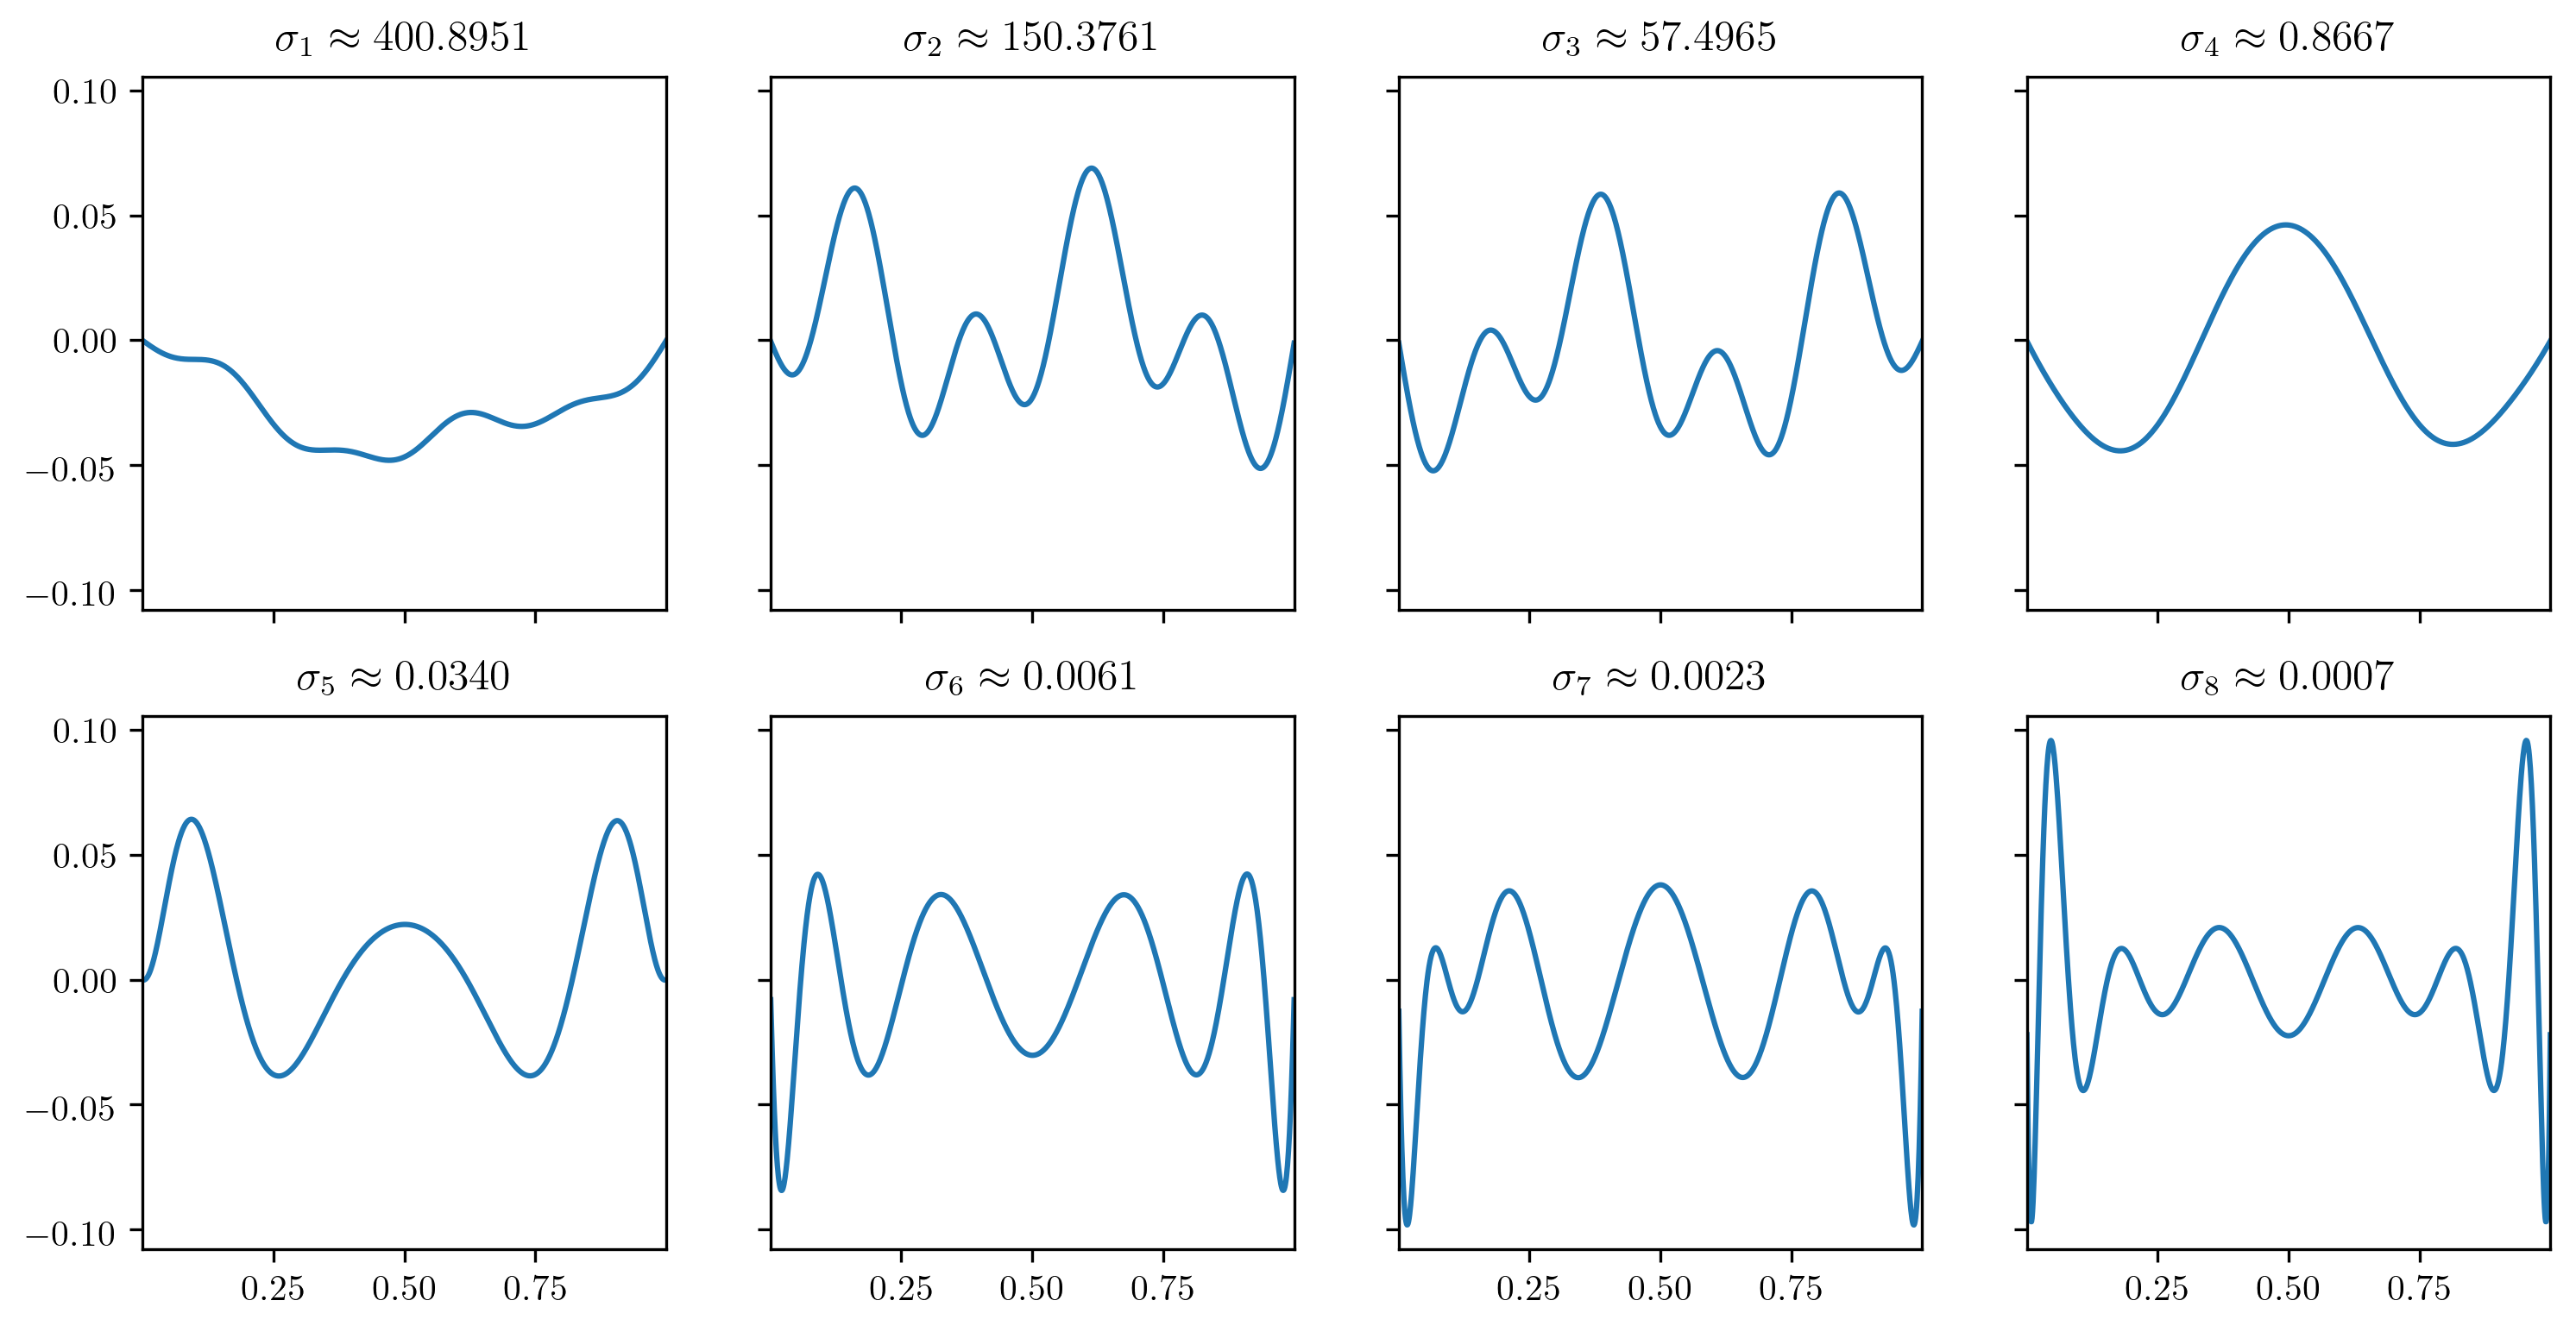

In [32]:
plot_basis_vectors(V, Xsvdvals, w)

Now that we have data $X$ and a basis $V$, we can compute the intrusive state matrix $\tilde{A} = V^\mathsf{T}(I - \delta t A)V$ and the operator inference state matrix $\hat{A}$ with re-projection.

In [33]:
Atilde = V.T @ spla.inv(sparse.csc_matrix(sparse.eye(n) - dt*A)) @ V
Atilde.shape

(8, 8)

In [34]:
Ahat = infer_linear_discrete_state_operator(reproject_discrete(FOM, V, x0, k))
Ahat.shape

(8, 8)

In [35]:
# The big test!
np.allclose(Ahat, Atilde)

True

In other words, we've essentially converted an implicit method into a reduced explicit method without inverting the matrix.

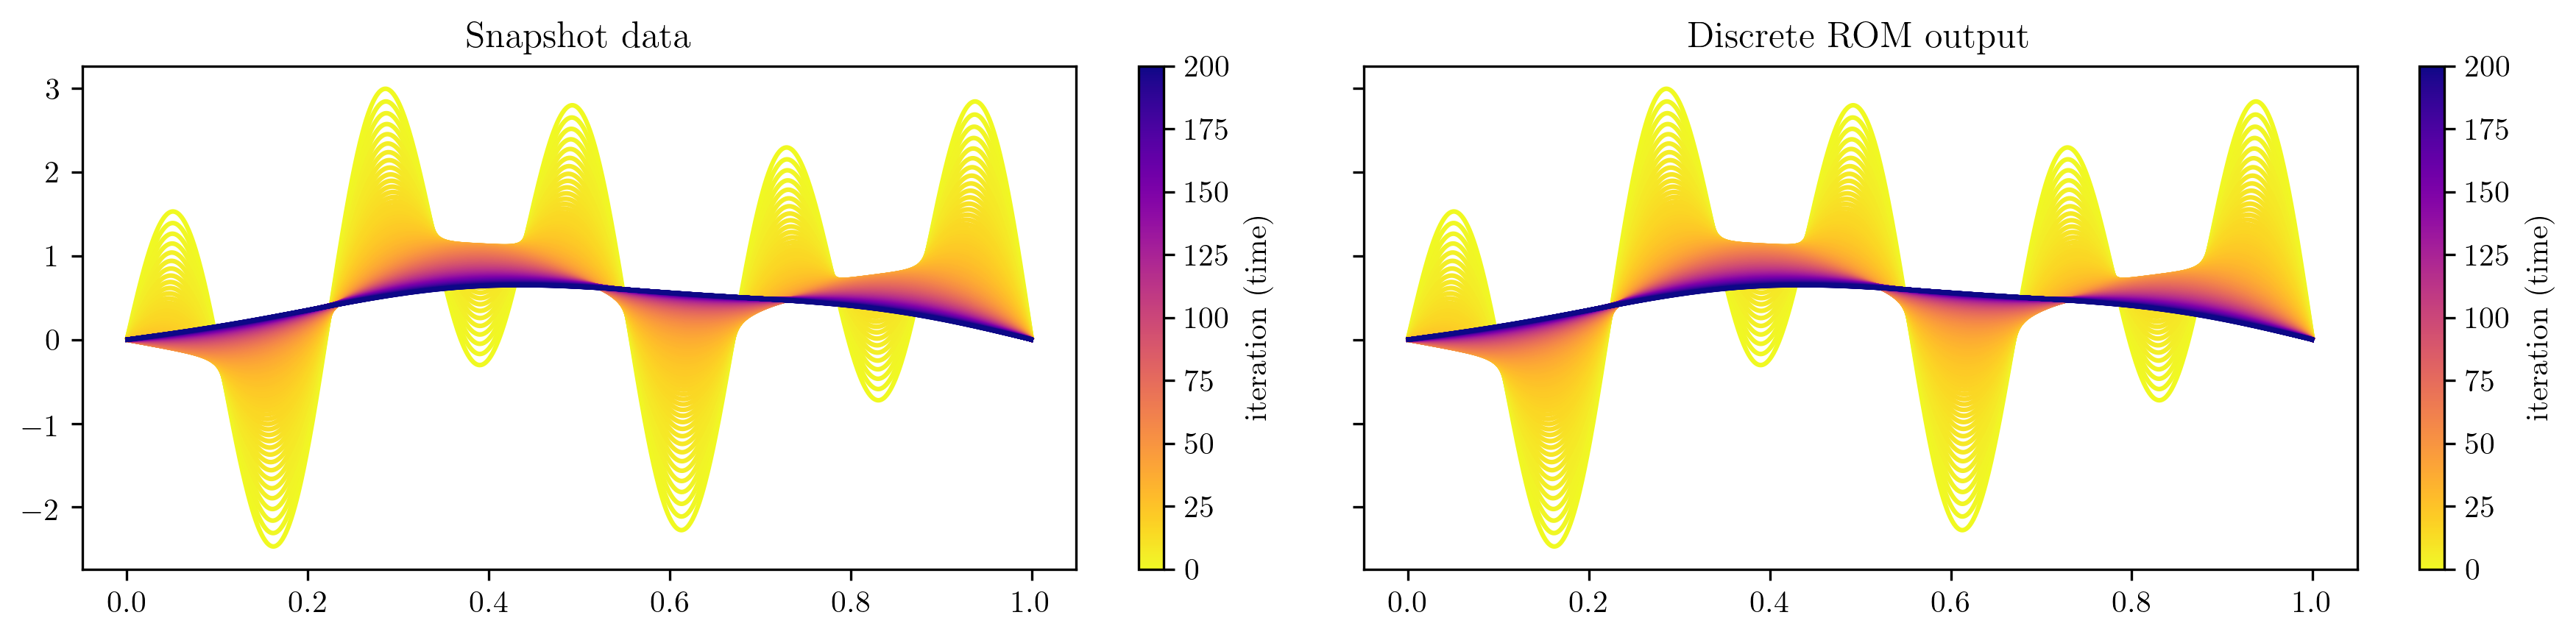

In [36]:
fig, [ax1, ax2] = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,3))
plot_heat_solution(X, title="Snapshot data", ax=ax1)
plot_heat_solution(V @ evolve_system(lambda x: Ahat @ x, V.T @ x0, k), title="Discrete ROM output", ax=ax2)
plt.tight_layout()
plt.show()

### Continuous Case

The previous examples learn a ROM for an ODE after it has already been discretized in time by a particular method (Implicit Euler).
More generally, we would like to learn a ROM for an ODE, which may then be discretized in any way.
In this setting, operator inference requires velocity snapshots $\{\hat{\mathbf{x}}_{j}\}_{j=1}^k$ that correspond to the state snapshots.
Vanilla operator inference sets $\hat{\mathbf{x}}_j = \mathbf{f}(\mathbf{x}_j)$, while re-projection sets $\hat{\mathbf{x}}_j = V^\mathsf{T}\mathbf{f}(V\hat{\mathbf{x}}_{j}) = V^\mathsf{T}\mathbf{f}(V V^\mathsf{T}\mathbf{x}_{j})$.
<!-- However, the intrusive operator is only recovered in the limit as $\delta t \to 0$ in the scheme that generates the snapshots. -->

In [37]:
def reproject_continuous(f, V, X):
    """Sample with re-projection trajectories of the continuous system
        dx / dt = f(t, x(t)),  x(0) = x0
    using the basis V for k time steps.

    Parameters
    ----------
    f : callable mapping (n,) ndarray to (n,) ndarray
        Function defining the differential equation.

    V : (n,r) ndarray
        Basis for the low-dimensional linear subspace.

    X : (n,k) ndarray
        State trajectories (training data).

    Returns
    -------
    X_ : (r,k) ndarray
        Re-projected state trajectories in the low-dimensional space.

    Xdot_ : (r,k) ndarray
        Re-projected velocities in the low-dimensional space.
    """
    n,k = X.shape
    X_ = V.T @ X
    Xdot_ = np.empty_like(X_)

    X_[:,0] = V.T @ x0
    for j in range(k):
        Xdot_[:,j] = V.T @ f(V @ X_[:,j])
    return X_, Xdot_

In [38]:
def infer_linear_continuous_state_operator(X_, Xdot_):
    """Solve the operator inference least squares problem for a linear continuous model.

    Parameters
    ----------
    X_ : (r,k) ndarray
        The projected trajectories (training data), i.e., X_ = V.T @ X.

    Xdot_ : (r,k) ndarray
        The projected velocities (training data), i.e., Xdot_ = V.T @ f(X).

    Returns
    -------
    Ahat : (r,r) ndarray
        The operator A_ in the reduced order model.
    """
    return la.lstsq(X_.T, Xdot_.T)[0].T

In this context, the goal is to recover the intrusive continuous state matrix $\tilde{A} = V^\mathsf{T}AV$.

In [39]:
# Instrusive state operator.
Atilde = V.T @ A @ V
Atilde.shape

(8, 8)

In [40]:
# Operator inference state operator (no reprojection).
Ahat = infer_linear_continuous_state_operator(V.T @ X, V.T @ A @ X)
Ahat.shape

(8, 8)

In [41]:
# Operator inference state operator with reprojection.
Ahatnew = infer_linear_continuous_state_operator(*reproject_continuous(lambda x: A @ x, V, X))
Ahatnew.shape

(8, 8)

In [42]:
la.norm(Atilde - Ahat) / la.norm(Atilde)

1.179017314108216e-10

In [43]:
la.norm(Atilde - Ahatnew) / la.norm(Atilde)

5.213208155748686e-12

In this test, plain operator inference yields an $\hat{A}$ that is already very close to $\tilde{A}$, but the re-projected $\hat{A}$ is a few magnitudes closer to $\tilde{A}$.
To investigate further, we redo the experiment with various time steps and compare the vanilla and re-projected $\hat{A}$ to $\tilde{A}$.

In [44]:
def hat_errors(dt):
    """Return the Frobenius norm errors of the operator inference state
    matrices (vanilla and reprojected) compared to the intrusive state matrix.
    """
    # k = int(1 / dt)
    X = evolve_system(lambda x: implicit_euler_step(A, x, dt), x0, k)
    V = la.svd(X)[0][:,:8]
    Atilde = V.T @ A @ V
    Ahat = infer_linear_continuous_state_operator(V.T @ X, V.T @ A @ X)
    Ahatnew = infer_linear_continuous_state_operator(*reproject_continuous(lambda x: A @ x, V, X))
    return la.norm(Atilde - Ahat), la.norm(Atilde - Ahatnew)

In [45]:
dts = np.logspace(-5, -1, 5)
err1, err2 = zip(*[hat_errors(dt) for dt in dts])

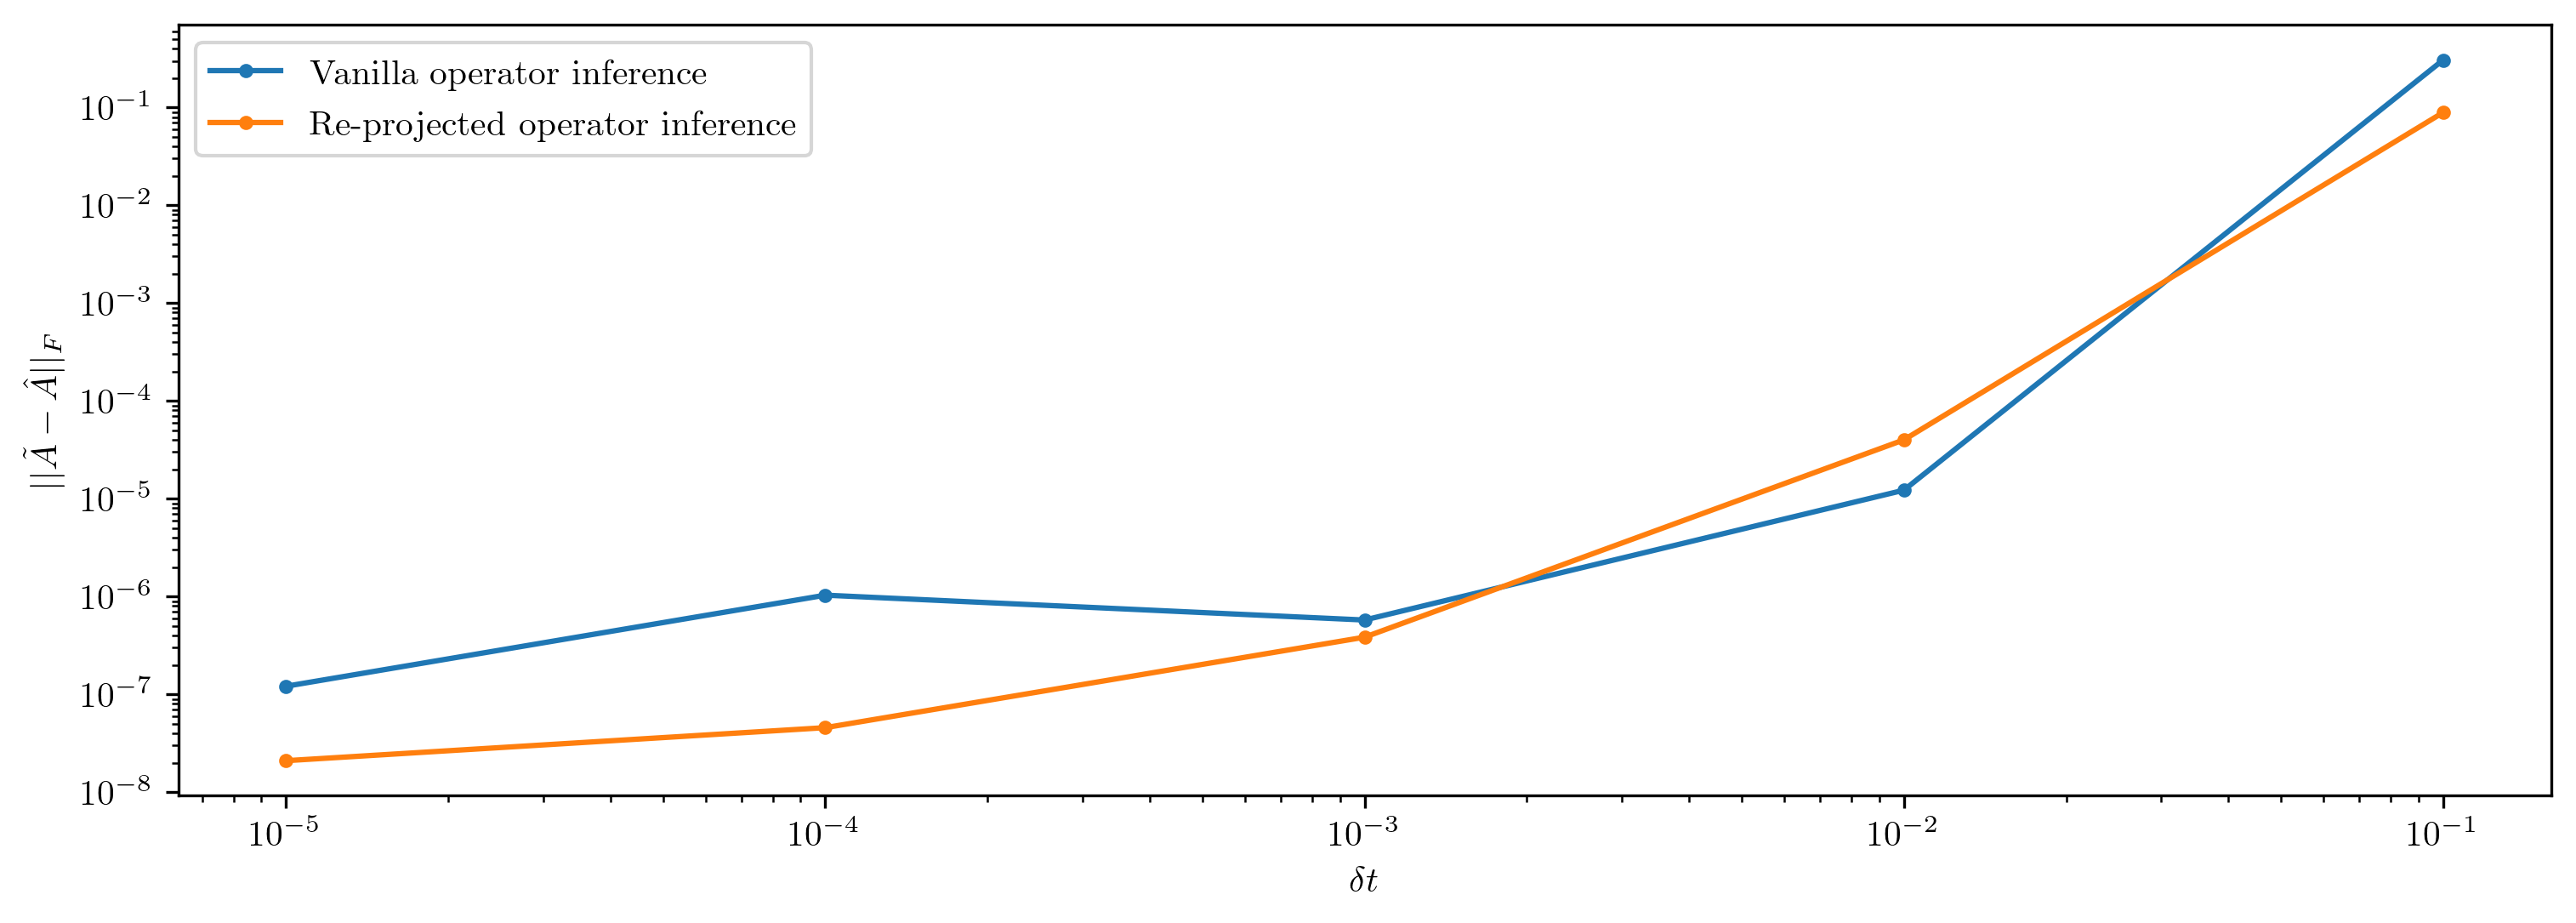

In [46]:
plt.loglog(dts, err1, '.-', label="Vanilla operator inference")
plt.loglog(dts, err2, '.-', label="Re-projected operator inference")
plt.legend(loc="upper left")
plt.xlabel(r"$\delta t$")
plt.ylabel(r"$||\tilde{A} - \hat{A}||_F$")
plt.show()

## Example 2: Burgers' Equation

$$
\begin{align*}
    \frac{\partial x}{\partial t} + x\frac{\partial x}{\partial \omega} - \mu\frac{\partial^2 x}{\partial \omega^2}
    &= 0
    &
    &\forall (\omega,t) \in (-1,1)\times (0,T]
    \\
    x(-1,t) = u(t),\quad x(1,t)
    &= -u(t)
    &
    &\forall t \in [0,T],
    \\
    x(\omega,0) &= 0
    &
    &\forall \omega \in [-1,1].
\end{align*}
$$

Let $\{\omega_i\}_{i=0}^{n+1}$ be an equidistant grid of $n$ points on $\Omega = [-1,1]$, i.e.,
$$
\begin{align*}
    -1 &= \omega_1 < \omega_2 < \cdots < \omega_{n-1} < \omega_{n} = 1
    &
    &\text{and}
    &
    \delta\omega &= \frac{L}{n+1} = \omega_{i+1} - \omega_{i},\quad i=1,\ldots,n-1.
\end{align*}
$$

We will include the boundary points $x_1$ and $x_n$ in the scheme since the boundary condition varies according to the input.
Therefore, our goal is to compute the state vector

$$
\mathbf{x}(t) = \left[\begin{array}{c} x(\omega_1,t) \\ \vdots \\ x(\omega_n,t)\end{array}\right]\in\mathbb{R}^n
$$

for various $t\in[0,T]$.

Again, we use finite difference approximations:

$$
\begin{align*}
    \frac{\partial^2}{\partial\omega^2}x_{i} &\approx \frac{x_{i-1} - 2x_{i} + x_{i+1}}{(\delta\omega)^2},
    &
    \frac{\partial}{\partial\omega}x_{i} &\approx\frac{x_{i+1} - x_{i-1}}{2\delta\omega}.
\end{align*}
$$

resulting in the semi-discrete linear system

$$
    \frac{d}{dt}\mathbf{x}(t) = \bar{A}\mathbf{x}(t) + \bar{H}\left(\mathbf{x}(t)\otimes\mathbf{x}(t)\right) + \bar{B}u(t),
    \qquad
    \mathbf{x}(0) = \mathbf{0}.
$$

Next, discretizing in time with Explicit Euler,

$$
    \mathbf{x}_{j+1}
    = \mathbf{x}_{j} + \delta t f(\mathbf{x}_{j})
    = \mathbf{x}_{j} + \delta t \left(\bar{A}\mathbf{x}_{j} + \bar{H}\left(\mathbf{x}_{j}\otimes\mathbf{x}_{j}\right) + \bar{B}u_{j}\right)
    \quad\Longrightarrow\quad
    \mathbf{x}_{j+1} = \underbrace{(I + \delta t \bar{A})}_{A}\mathbf{x}_{j} + \underbrace{\delta t \bar{H}}_{H}\left(\mathbf{x}_{j}\otimes\mathbf{x}_{j}\right) + \underbrace{\delta t \bar{B}}_{B}u_{j}.
$$

Thus, the full-order model has the form
$$
    \boxed{\mathbf{x}_{j+1} = A\mathbf{x}_{j} + H\left(\mathbf{x}_{j}\otimes\mathbf{x}_{j}\right) + Bu_{j},
    \qquad
    \mathbf{x}_{0} = \mathbf{0}}\,.
$$

In [47]:
# Construct the spatial domain.
n = 2**7 + 1                    # Spatial grid size.
w = np.linspace(-1, 1, n)       # Full spatial grid.
dw = w[1] - w[0]                # Spatial resolution.

# Construct the temporal domain.
T = 1;                          # Temporal domain length (final simulation time).
k = T*10**4 + 1                 # Temporal grid size.
t = np.linspace(0, T, k)        # Temporal grid.
dt = 1e-4                       # Temporal resolution.

# Choose some parameters.
U = np.sin(4*t)                 # Training inputs.
mu = 0.1                        # Diffusion coefficient.

In [48]:
def burgers_linear(mu, n, dw, dt):
    """Build the state matrix A for Burgers' equation."""
    # Spatial discretization
    A = sparse.diags(np.array([1,-2,1]) * mu / dw**2, [-1,0,1], (n,n)).todok()
    A[0,0] = 1
    A[0,1] = 0
    A[-1,-1] = 1
    A[-1,-2] = 0

    # Temporal discretization
    return sparse.csc_matrix(sparse.eye(n) + dt*A)

def burgers_quadratic(n, dw, dt):
    """Build the compact quadratic state matrix Hc for Burgers' equation."""
    # Spatial discretization
    entry = 1 / (2*dw)
    i = np.arange(n)
    j = i*(i+3)//2 - 1
    Hc = sparse.dok_matrix((n,n*(n+1)//2), dtype=np.int)
    Hc[i[1:-1],j[2:]] = entry
    Hc[i[1:-1], j[1:-1]] = -entry

    # Temporal discretization
    return sparse.csc_matrix(dt * Hc)

def burgers_input(n, dt):
    """Build the input matrix B for Burgers' equation."""
    # Spatial discretization
    B = np.zeros(n)

    # Temporal discretization
    B[0], B[-1] = -dt, dt
    return B

In [49]:
def kron_compact(x):
    """Calculate the unique terms of the Kronecker product x ⊗ x.

    Parameters
    ----------
    x : (n,) or (n,k) ndarray
        If two-dimensional, the product is computed column-wise (Khatri-Rao).

    Returns
    -------
    x ⊗ x : (n(n+1)/2,) or (n(n+1)/2,k) ndarray
        The "compact" Kronecker product of x with itself.
    """
    if x.ndim not in (1,2):
        raise ValueError("x must be one- or two-dimensional")
    return np.concatenate([x[i]*x[:i+1] for i in range(x.shape[0])], axis=0)

In [50]:
A = burgers_linear(mu, n, dw, dt)       # Linear state matrix.
Hc = burgers_quadratic(n, dw, dt)       # Quadratic state matrix.
B = burgers_input(n, dt)                # Input matrix.
x0 = np.zeros(n)                        # Initial condition.

def FOM(x, u):
    """Do a single step of the full-order model."""
    return A @ x + Hc @ kron_compact(x) + B*u

In [51]:
X = evolve_system(FOM, x0, k, U)

In [52]:
r = 20
V = la.svd(X, full_matrices=False)[0][:,:r]

In [53]:
def compress_H(H):
    """Calculate the matricized quadratic operator that operates on the compact
    Kronecker product.

    Parameters
    ----------
    H : (r,r**2) ndarray
        The matricized quadratic tensor that operates on the Kronecker product.
        This should be a symmetric operator in the sense that each layer of
        H.reshape((r,r,r)) is a symmetric (r,r) matrix, but it is not required.

    Returns
    -------
    F : (r,s) ndarray
        The matricized quadratic tensor that operates on the COMPACT Kronecker
        product. Here s = r * (r+1) / 2.
    """
    r = H.shape[0]
    r2 = H.shape[1]
    if r2 != r**2:
        raise ValueError(f"invalid shape (r,a) = {(r,r2)} with a != r**2")
    s = r * (r+1) // 2
    F = np.zeros((r, s))

    fj = 0
    for i in range(r):
        for j in range(i+1):
            if i == j:      # Place column for unique term.
                F[:,fj] = H[:,(i*r)+j]
            else:           # Combine columns for repeated terms.
                fill = H[:,(i*r)+j] + H[:,(j*r)+i]
                F[:,fj] = fill
            fj += 1

    return F


def expand_Hc(F):
    """Calculate the matricized quadratic operator that operates on the full
    Kronecker product.

    Parameters
    ----------
    F : (r,s) ndarray
        The matricized quadratic tensor that operates on the COMPACT Kronecker
        product. Here s = r * (r+1) / 2.

    Returns
    -------
    H : (r,r**2) ndarray
        The matricized quadratic tensor that operates on the full Kronecker
        product. This is a symmetric operator in the sense that each layer of
        H.reshape((r,r,r)) is a symmetric (r,r) matrix.
    """
    r,s = F.shape
    if s != r*(r+1)//2:
        raise ValueError(f"invalid shape (r,s) = {(r,s)} with s != r(r+1)/2")

    H = np.zeros((r,r**2))
    fj = 0
    for i in range(r):
        for j in range(i+1):
            if i == j:      # Place column for unique term.
                H[:,(i*r)+j] = F[:,fj]
            else:           # Distribute columns for repeated terms.
                fill = F[:,fj] / 2
                H[:,(i*r)+j] = fill
                H[:,(j*r)+i] = fill
            fj += 1

    return H

In [54]:
# Calculate the intrusive operators.
Atilde = V.T @ A @ V
Hctilde = compress_H(V.T @ expand_Hc(Hc.toarray()) @ np.kron(V, V))
Btilde = V.T @ B

print("shape(Atilde):", Atilde.shape)
print("shape(Hctilde):", Hctilde.shape)
print("shape(Btilde):", Btilde.shape)

shape(Atilde): (20, 20)
shape(Hctilde): (20, 210)
shape(Btilde): (20,)


In [55]:
# Reproject the training trajectory.
X_reprojected = reproject_discrete(FOM, V, x0, k, U)

In [56]:
def infer_discrete_burgers_operators(X_, U):
    """Solve the operator inference least squares problem for a quadratic discrete model with inputs.

    Parameters
    ----------
    X_ : (r,k) ndarray
        The projected trajectory (training data), i.e., X_ = V.T @ X.

    U : (k,) ndarray
        Scalar inputs corresponding to the training data.

    Returns
    -------
    Ahat : (r,r) ndarray
        The operator A_ in the reduced order model.

    Hchat : (r,r(r+1)/2) ndarray
        The operator Hc_ in the reduced order model.

    Bhat : (r,) ndarray
        The operator B_ in the reduced order model.
    """
    D = np.hstack([X_[:,:-1].T, kron_compact(X_[:,:-1]).T, U[:-1].reshape((-1,1))])
    R = X_[:,1:].T
    print("Condition number of data matrix:", np.linalg.cond(D))
    O = la.lstsq(D, R)[0].T
    n = X_.shape[0]
    return O[:,:n], O[:,n:n + n*(n+1)//2], O[:,-1].flatten()

In [57]:
Ahat, Hchat, Bhat = infer_discrete_burgers_operators(X_reprojected, U)

Condition number of data matrix: 1.4170723629978692e+29


In [58]:
Ahat.shape

(20, 20)

In [59]:
Hchat.shape

(20, 210)

In [60]:
Bhat.shape

(20,)

In [61]:
# Decent
la.norm(Atilde - Ahat) / la.norm(Atilde)

0.22511354176077852

In [62]:
# Good
la.norm(Btilde - Bhat) / la.norm(Btilde)

1.4846475535866827e-06

In [63]:
# Not as good
la.norm(Hctilde - Hchat) / la.norm(Hctilde)

164.75909430720182

Overall this is pretty good, considering the condition number of the data matrix is $\mathrm{cond}(D) \approx 10^{29}$.